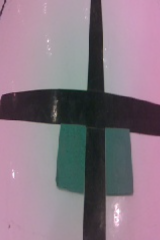

DECISION IS:  turn


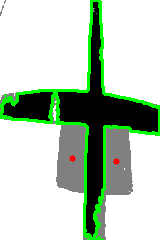

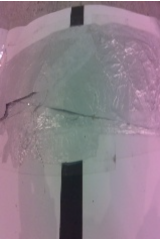

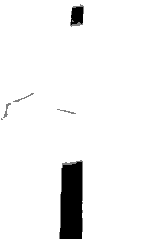

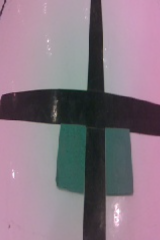

DECISION IS:  turn


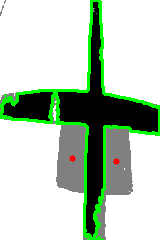

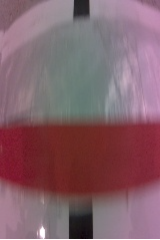

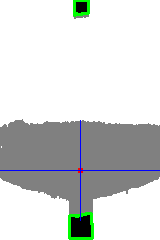

DECISION IS:  forward


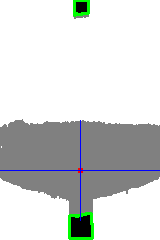

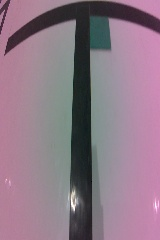

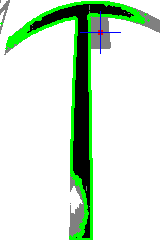

DECISION IS:  right


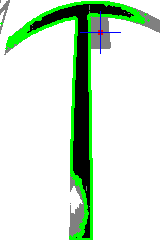

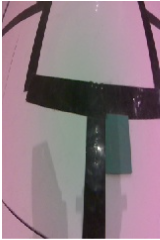

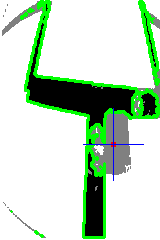

DECISION IS:  right


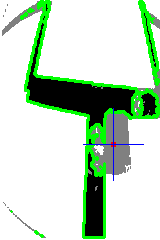

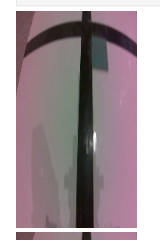

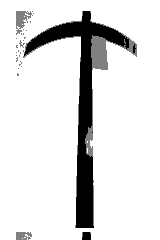

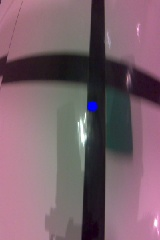

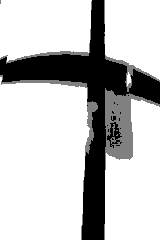

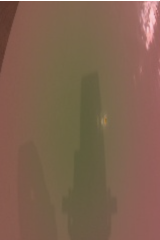

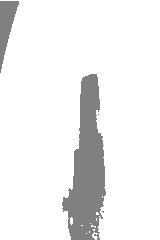

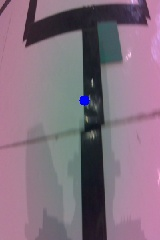

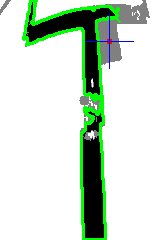

DECISION IS:  right


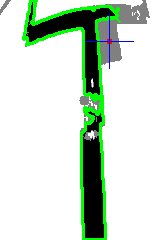

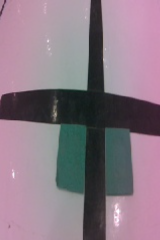

DECISION IS:  turn


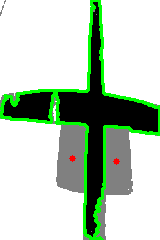

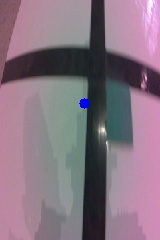

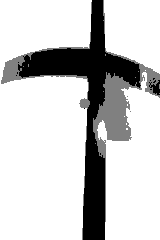

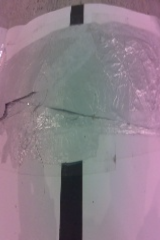

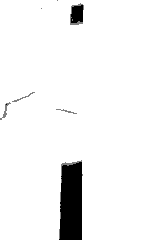

In [10]:
import cv2
import numpy as np
from IPython.display import display, Image
import os

def decision_making(right,left,up,down):
    if right and up:
        decision = "left"
    elif left and up:
        decision = "right"
    elif left and down:
        decision = "forward"
    elif right and down:
        decision = "forward"
    else:
        decision = "forward"
    return decision

def check_contour_proximity(midpoint, rectangle, contours, image, image_shape):
    up, down, left, right = False, False, False, False
    x, y = midpoint
    rect_height = rectangle[3]  # Assuming rectangle is (x, y, w, h)
    rect_width = rectangle[2]
    color_blue = (255, 0, 0)  # Blue color in BGR
    
    line_segments = {
        #leaving 5 pixels for tolerance
        'up':    ((x, y), (x, y - (rect_height // 2 + 5)  )),
        'down':  ((x, y), (x, y + (rect_height // 2 + 5) )),
        'left':  ((x, y), (x - rect_width, y)),
        'right': ((x, y), (x + rect_width, y))
    }

    # Draw line segments on the image
    for direction, (pt1, pt2) in line_segments.items():
        cv2.line(image, pt1, pt2, color_blue, 1)  # Draw blue line on the image

    # Now check each contour for intersection with line segments
    for direction, (pt1, pt2) in line_segments.items():
        line_img = np.zeros(image_shape[:2], dtype=np.uint8)  # Create a blank single-channel image
        cv2.line(line_img, pt1, pt2, 255, 1)  # Draw line segment
        intersect_img = cv2.bitwise_and(line_img, line_img, mask=cv2.drawContours(np.zeros_like(line_img), contours, -1, 255, -1))
        
        if np.any(intersect_img):  # Check if there is any intersection
            if direction == 'up':
                up = True
            elif direction == 'down':
                down = True
            elif direction == 'left':
                left = True
            elif direction == 'right':
                right = True

    return up, down, left, right, image  # Return the image for visualization


def detect_collision(frame):
    resized_frame = cv2.resize(frame, (160, 240))
    
    print(resized_frame.shape)

    frame_with_lines = resized_frame.copy()

    # Convert the image to RGB mode
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Calculate the average of R, G, and B channels
    average_image = np.mean(rgb_image, axis=2).astype(np.uint8)

    # Threshold the average image to create three shades of grey
    threshold_value = 50
    mid_threshold = 40
    black_mask = average_image < threshold_value
    white_mask = average_image >= (threshold_value + mid_threshold)
    middle_gray_mask = np.logical_and(
        average_image >= threshold_value, average_image < (threshold_value + mid_threshold)
    )
    
    black_mask_area = np.count_nonzero(black_mask)
    white_mask_area = np.count_nonzero(white_mask)
    gray_mask_area = np.count_nonzero(middle_gray_mask)
    
    print("gray mask area is: ", gray_mask_area)
    print("white mask area is: ", white_mask_area)
    print("black mask area is:", black_mask_area)
    
    black_area_max_threshold = 9500
    white_area_min_threshold = 15000
    white_area_max_threshold = 38500
    gray_area_max_threshold = 4500

    # Check if the current frame's area sizes are outside these thresholds
    collision_detected = False
    if (black_mask_area > black_area_max_threshold or
        white_mask_area < white_area_min_threshold or white_mask_area > white_area_max_threshold or gray_mask_area > gray_area_max_threshold):
        collision_detected = True
        print("Potential collision detected!")
    
#     return collision_detected

# Define cluster size thresholds
min_cluster_width = 13
min_cluster_height = 13

# Function to find midpoints of clusters in a mask and calculate their sizes
def find_midpoints_and_sizes(mask, min_width, min_height):
    min_area = 450
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    midpoints = []
    sizes = []
    aspect_ratios = []  # Store aspect ratios here
    rectangles = []  # Store rectangles here
    valid_contours = []  # To store contours that are likely to be rectangles
    contour_areas = []  # Store contour areas here
    
    for contour in contours:
        # Approximate the contour to simplify its shape
        epsilon = 0.09 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the approximated contour has about 4 vertices (rectangle-like)
        if len(approx) == 4:
            area = cv2.contourArea(approx)

            # Only proceed if the contour area is within the specified range
            if area >= min_area:
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)

                # Store area and other data in the lists
                contour_areas.append(area)
                midpoint = (x + w//2, y + h//2)
                midpoints.append(midpoint)
                sizes.append(w * h)
                aspect_ratios.append(aspect_ratio)
                rectangles.append((x, y, w, h))
                valid_contours.append(approx)  # Store the approximated contour
    
    # After processing all contours, print out the contour areas
#     print("Contour Areas:", contour_areas)
    return midpoints, sizes, rectangles, aspect_ratios, valid_contours

# Function to draw midpoints on the image
def draw_midpoints_and_contours(img, midpoints, contours, color):
    # Draw midpoints on each contour
    for point in midpoints:
        cv2.circle(img, point, radius=3, color=color, thickness=-1)  # -1 thickness fills the circle

# Function to process each image
def process_image(image_path):
    image = cv2.imread(image_path)
    output_image = cv2.resize(image, (160, 240))
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Display the original image
    display(Image(data=cv2.imencode('.png', output_image)[1].tobytes()))

    # Convert the image to RGB mode
    rgb_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Calculate the average of R, G, and B channels
    average_image = np.mean(rgb_image, axis=2).astype(np.uint8)

    # Threshold the average image to create three shades of grey
    threshold_value = 50
    mid_threshold = 40
    black_mask = average_image < threshold_value
    white_mask = average_image >= (threshold_value + mid_threshold)
    middle_gray_mask = np.logical_and(
        average_image >= threshold_value, average_image < (threshold_value + mid_threshold)
    )

    # Create an output image with three shades of grey
    output_image = np.zeros_like(rgb_image)
    output_image[black_mask] = [0, 0, 0]  # Black
    output_image[white_mask] = [255, 255, 255]  # White
    output_image[middle_gray_mask] = [128, 128, 128]  # Middle Grey

    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological opening to the middle gray mask
    opened_mask = cv2.morphologyEx(middle_gray_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Calculate midpoints for middle gray regions, their sizes, rectangles, aspect ratios, and contours
    middle_gray_midpoints, middle_gray_sizes, middle_gray_rectangles, current_aspect_ratios, valid_contours = find_midpoints_and_sizes(opened_mask, min_cluster_width, min_cluster_height)

    # Sort the sizes and associated aspect ratios, rectangles, and contours in descending order
    sorted_data = sorted(zip(middle_gray_sizes, middle_gray_rectangles, current_aspect_ratios, valid_contours), reverse=True)
    sorted_sizes, sorted_rectangles, sorted_aspect_ratios, sorted_contours = zip(*sorted_data) if sorted_data else ([], [], [], [])
    
    # Draw midpoints and contours for middle gray regions on the output image
    draw_midpoints_and_contours(output_image, middle_gray_midpoints, sorted_contours, color=(0, 0, 255))
    
    #Only do this if the image has a rectangle with a midpoint
    if len(middle_gray_midpoints) > 0:
        # Find and draw contours for the black areas
        black_mask_uint8 = black_mask.astype(np.uint8) * 255
        contours, _ = cv2.findContours(black_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        black_contours = contours
        cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)  # Drawing green contours
    
        if len(middle_gray_midpoints) == 2:
            decision = "turn"
        elif len(middle_gray_midpoints) == 1:    
            for midpoint, rectangle in zip(middle_gray_midpoints, middle_gray_rectangles):
                up, down, left, right, output_image = check_contour_proximity(midpoint, rectangle, black_contours, output_image, output_image.shape)
                decision = decision_making(right,left,up,down)
            display(Image(data=cv2.imencode('.png', output_image)[1].tobytes()))
        print("DECISION IS: ", decision)

    # Display the final image with midpoints and green contours
    display(Image(data=cv2.imencode('.png', output_image)[1].tobytes()))
    
# # Path to the screenshots folder
folder_path = 'screenshots'

# List all files in the folder and process each image file
for file_name in os.listdir(folder_path):
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)
    if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        process_image(file_path)
#         image = cv2.imread(file_path)
#         detect_end(image)